# LSBG Physical Size Distribution

In this notebook, we estimate the LSBG physical size distribution and add cuts based on surface brightness to calculate the proportion of the sample that meets the qualifications for an Ultra-Diffuse-Galaxy. 

## Imports

* We use numpy for numerical calculations and analysis
* We use matplotlib for plotting
* We use scipy and random for statistical analysis
* We use pandas to load in files
* We use astropy for cosmology to calculate distances

In [1]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.stats import norm
from random import sample
import pandas as pd
from astropy.cosmology import Planck15
from astropy import units as u
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading Data

We load in the lens catalog of LSBGs from [Tanoglidis+2020](2006.04294) and extract the g-band photometry and central surface brightness, the i-band photometry, the r-band photometry, and the apparent radii (in angular scales). We also define and apply the blue and red color-masks. We construct the central surface brightness mask used to qualify galaxies as UDGs. We load in the blue and red redshift distributions. 

In [2]:
#Loading lens catalog
lens_file=pd.read_csv(r'../data/LSBG_catalog_v2.csv')
lens=pd.DataFrame(lens_file, columns= ['ra_se','dec_se', 'mag_gfm_g_corr', 'magerr_gfm_g', 'mag_gfm_i_corr','magerr_gfm_i', 'mag_gfm_r_corr','magerr_gfm_r','r_eff_r', 'r_eff_g', 'r_eff_i', 'mu_0_g'])



In [3]:
#Loading g-band photometry and central surface brightness
g = lens['mag_gfm_g_corr']
g_err = lens['magerr_gfm_g']
g_central = lens['mu_0_g']

In [4]:
i = lens['mag_gfm_i_corr'] #i-band photometry
i_err = lens['magerr_gfm_i']

In [5]:
r = lens['mag_gfm_r_corr'] #r-band photometry 
r_err = lens['magerr_gfm_r']

In [6]:
r_eff_g = lens['r_eff_g'] #apparent radii (angular scales) in g,r,i-band
r_eff_r = lens['r_eff_r']
r_eff_i = lens['r_eff_i']

In [7]:
mask_blue = (g-i)<=0.60  #red and blue LSBG masks
mask_red = (g-i)>=0.60
red_lens = lens[mask_red]
blue_lens = lens[mask_blue]

In [8]:
#Building red and blue photometric samples
g_red = red_lens['mag_gfm_g_corr']
g_blue = blue_lens['mag_gfm_g_corr']
g_err_red = red_lens['magerr_gfm_g']
g_err_blue = blue_lens['magerr_gfm_g']

i_red = red_lens['mag_gfm_i_corr']
i_blue = blue_lens['mag_gfm_i_corr']
i_err_red = red_lens['magerr_gfm_i']
i_err_blue = blue_lens['magerr_gfm_i']

r_red = red_lens['mag_gfm_r_corr']
r_blue = blue_lens['mag_gfm_r_corr']
r_err_red = red_lens['magerr_gfm_r']
r_err_blue = blue_lens['magerr_gfm_r']


In [9]:
r_eff_g_red = red_lens['r_eff_g'] #red and blue apparent radii
r_eff_g_blue = blue_lens['r_eff_g']

r_eff_i_red = red_lens['r_eff_i']
r_eff_i_blue = blue_lens['r_eff_i']

r_eff_r_red = red_lens['r_eff_r']
r_eff_r_blue = blue_lens['r_eff_r']


In [10]:
g_central_red = red_lens['mu_0_g'] #red and blue central surface brightness
g_central_blue = blue_lens['mu_0_g']

In [11]:
mask_g_cen_red = (np.array(g_central_red)>24.0) #central surface brightness masks for UDGs
mask_g_cen_blue = (np.array(g_central_blue)>24.0)

In [12]:
zldist_red_fiducial = np.loadtxt('../data/zldist_red') #redshift distribution
zldist_blue_fiducial = np.loadtxt('../data/zldist_blue')
zlrange_red = np.linspace(0.005, 0.135, 14)
zlrange_blue = np.linspace(0.01, 0.19, 10)


## Function Definitions

We define each of the functions used in this notebook, grouped here for ease of access.

### Apparent Radii Distribution

We define a function that plots the distribution of apparent radii for the selected LSBG samples, with and without the central surface brightness cut for UDGs. We calculate the proportion of selected LSBGs that pass the central surface brightness cut.

In [13]:
def app_radii(r_eff=None, color=None, cen_brightness_mask=None):
    """
    Plots the distribution of the apparent radii and calculates the proportion that pass the central surface brightness cut
    
    r_eff = apparent radii (arcsec)
    color = string for plotting color 
    cen_surface_brightness_mask = selected mask for extracting galaxies that pass the UDG surface brightness cut
    
    Returns: plot of apparent radii, proportion of sample that passes central surface brightness cut
    """
    
    plt.hist(r_eff, color=color, histtype = 'step', lw = 2., alpha=0.7, bins=30, label='LSBGs')
    plt.hist(r_eff[cen_brightness_mask], color=color, alpha=0.7, bins=30, label='$\mu_g>24$')
    plt.yscale('log')
    plt.xlabel('$R_\mathrm{eff, g}$ [arcsec]', fontsize=16)
    plt.ylabel('$n(\\theta)$')
    plt.xlim(0, 25)
    plt.legend(frameon=False)
    plt.show()
    n_gal = len(r_eff)
    n_gal_central_cut = len(r_eff[cen_brightness_mask])
    pass_central_cut= n_gal_central_cut/n_gal
    print('Out of %d LSBGs, %d pass the central surface brightnes cut.'%(n_gal,n_gal_central_cut))
    print('%0.2f percentage of LSBGs pass the central surface brightnes cut.'%pass_central_cut)
    return (n_gal, n_gal_central_cut, pass_central_cut)


### Physical Radius

We define a function that converts between the observed radius and the physical radius, using a redshift and base cosmology.

In [14]:
def phys_radius_single_z(r_eff, z):
    """
    Converts from the apparent radius to the physical radius 
    
    r_eff = apparent radius in angular scales (arcseconds)
    z = single redshift
    
    Returns: physical radius
    """
    da_xi = Planck15.angular_diameter_distance(z)*1000*u.kpc #Mpc to kpc
    r_phys = da_xi*(r_eff/3600*np.pi/180)
    return r_phys

We define a function that calculates the distribution of physical radii corresponding to the distribution of apparent radii for galaxies that do and do not meet the UDG central surface brightness cut. Each discrete redshift thus corresponds to a distribution of physical radii, which we plot as histograms. 

In [15]:
def phys_radius_dist_ind(r_eff=None, zlrange=None, cen_brightness_mask=None):
    """
    Builds the distribution of physical radii corresponding to each point in the redshift distribution 
    
    r_eff = apparent radii (arcseconds)
    zlrange = range of redshift distribution
    cen_brightness_mask = UDG central surface brightness mask
    
    Returns: histogram of physical radii corresponding to different redshifts
    """

    colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']
    r_effs = []
    r_hists = []
    r_effs_udg = []
    r_hists_udg = []

    for i, z in enumerate(zlrange):
        r_eff_z_udg = phys_radius_single_z(r_eff[cen_brightness_mask], z = z)
        r_eff_z = phys_radius_single_z(r_eff, z = z)
        r_effs.append(r_eff_z)
        r_effs_udg.append(r_eff_z_udg)
        # let's save the counts and bin edges in the histogram, let's make the histogram finely grid, and fixed accross z-bins
        r_hist, bin_edges = np.histogram(r_eff_z, bins = 100, range=(0, 20))
        r_hist_udg, bin_edges_udg = np.histogram(r_eff_z_udg, bins = 100, range=(0, 20))
        r_hists.append(r_hist)
        r_hists_udg.append(r_hist_udg)
        plt.hist(r_eff_z, histtype = 'step', color=colors[i%7], alpha=0.7, bins=30, label='z=%0.3f'%z)    
    plt.yscale('log')
    plt.xlabel('$R_\mathrm{eff, g}$ [kpc]', fontsize=16)
    plt.ylabel('$n(\\theta)$')
    plt.xlim(0, 30)
    plt.legend(frameon=False)
    r_effs = np.array(r_effs)
    r_hists = np.array(r_hists)
    return r_hists, r_hists_udg, bin_edges, bin_edges_udg

We define a function that calculates the means of the physical radius bins (kpc) and plots the normalized distribution corresponding to each redshift. 

In [16]:
def bin_mean(bin_edges=None, zldist=None, r_hists=None):
    """
    Calculates the means of the physical radius bins and plots the distribution of physical radii as a function of them
    
    bin_edges = edges of bins 
    zldist = normalized redshift distribution
    r_hists = array of histograms of physical radii
    
    Returns: bin means, plot of normalized physical radii distributions
    """
    bin_means = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2. 
    for i in range(len(r_hists)):
        plt.plot(bin_means, r_hists[i]*zldist[i])
    plt.xlabel('$R_\mathrm{eff, g}$ [kpc]', fontsize=16)
    plt.ylabel('$n(\\theta)$')
    plt.xlim(0, 15)
    plt.show()
    return bin_means

To produce the final distribution corresponding to a range of redshifts, we calculate the weighted sums of the physical radii distributions corresponding to the discrete redshifts for both the red and blue LSBG samples. This is shown as follows: $$n(R_\mathrm{eff, phys}) = \frac{\Sigma(n(R_\mathrm{eff, phys}(z_L, R_\mathrm{eff, \theta})) n(z_L)}{\Sigma n(z_L)}.$$ We perform this procedure for the galaxies that do and do not meet the surface brightness cut for UDGs.

In [17]:
def phys_radius_dist(r_hists=None, r_hists_udg=None, zldist=None, bin_means=None, color=None):
    """
    Calculates and plots the physical radius distribution corresponding to a range of redshifts
    r_hists = histogram of physical radii corresponding to each point in the redshift distribution
    r_hists_udg = histogram of physical radii corresponding to each point in the redshift distribution that meet the UDG cutoff
    zldist = redshift distribution
    bin_means = means of physical radii bins
    color = selected plotting color
    
    Returns: physical distribution of LSBGs, physical distribution of UDGs
    
    """
    r_dist = np.sum(np.array(r_hists).T*zldist, axis = 1)/np.sum(zldist)
    r_dist_udg = np.sum(np.array(r_hists_udg).T*zldist, axis = 1)/np.sum(zldist)
    plt.plot(bin_means, r_dist, color = color, lw = 2, label='LSBGs')
    plt.plot(bin_means, r_dist_udg, color = color, lw = 2, ls='--', label='LSBGs with $\mu_0>24$')
    plt.axvline(x = 1.5, ls = ':', color = 'k')
    plt.xlabel('$R_\mathrm{eff, g}$ [kpc]', fontsize=16)
    plt.ylabel('N')
    plt.legend()
    plt.show()
    return r_dist, r_dist_udg

## Data Visualization

We plot the red and blue apparent radii distributions. 

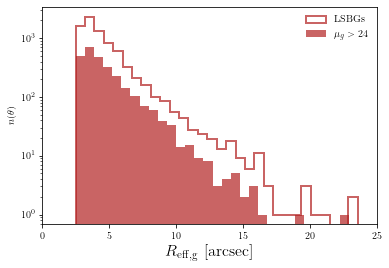

Out of 7805 LSBGs, 2744 pass the central surface brightnes cut.
0.35 percentage of LSBGs pass the central surface brightnes cut.


In [18]:
#histogram of apparent radii (red LSBGs)
n_gal_red, n_gal_central_red, pass_central_cut_red = app_radii(r_eff = r_eff_g_red, color='firebrick', cen_brightness_mask = mask_g_cen_red)

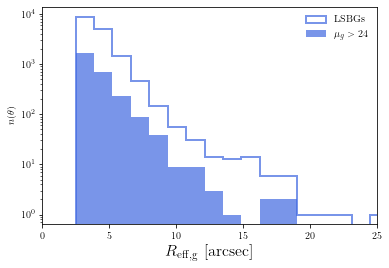

Out of 15985 LSBGs, 2726 pass the central surface brightnes cut.
0.17 percentage of LSBGs pass the central surface brightnes cut.


In [19]:
#histogram of apparent radii (blue LSBGs)
n_gal_blue, n_gal_central_cut_blue, pass_central_cut_blue = app_radii(r_eff = r_eff_g_blue, color='royalblue', cen_brightness_mask = mask_g_cen_blue)

We plot the physical radius distributions corresponding to each point in the redshift distribution. 

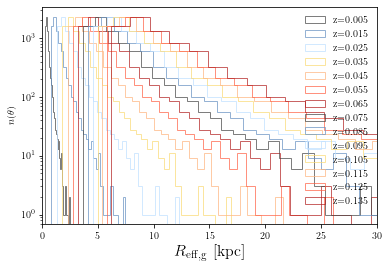

In [20]:
#Red LSBG sample
r_hists_red, r_hists_red_udg, bin_edges_red, bin_edges_udg_red = phys_radius_dist_ind(r_eff=r_eff_g_red, zlrange=zlrange_red, cen_brightness_mask=mask_g_cen_red)


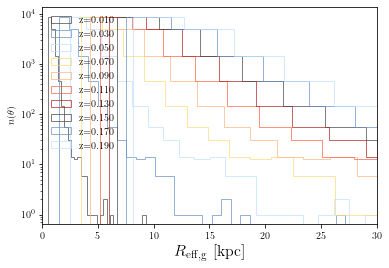

In [21]:
#Blue LSBG sample
r_hists_blue, r_hists_blue_udg, bin_edges_blue, bin_edges_udg_blue = phys_radius_dist_ind(r_eff=r_eff_g_blue, zlrange=zlrange_blue, cen_brightness_mask=mask_g_cen_blue)


We construct bin means for the red and blue LSBG samples based on their repsective physical radii distribution. We then plot the distribution of sizes corresponding to each redshift for the red and blue LSBG samples.

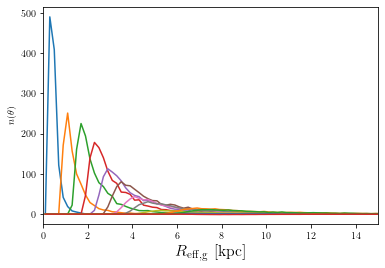

In [22]:
bin_means_red = bin_mean(bin_edges=bin_edges_red, zldist=zldist_red_fiducial, r_hists=r_hists_red)

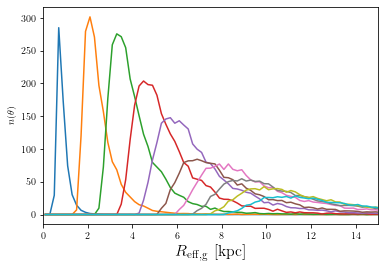

In [23]:
bin_means_blue = bin_mean(bin_edges=bin_edges_blue, zldist=zldist_blue_fiducial, r_hists=r_hists_blue)


We combine the individual, redshift-bin specific distributions to produce a physical size distribution for both the red and blue LSBG samples. We plot the red and blue physical size distributions for galaxies that do and do not meet the surface brightness cutoff and include a dashed vertical line to represent the 1.5kpc cutoff.

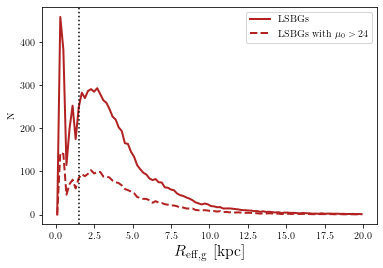

In [24]:
r_dist_red, r_dist_udg_red = phys_radius_dist(r_hists=r_hists_red, r_hists_udg=r_hists_red_udg, zldist=zldist_red_fiducial, bin_means=bin_means_red, color='firebrick')


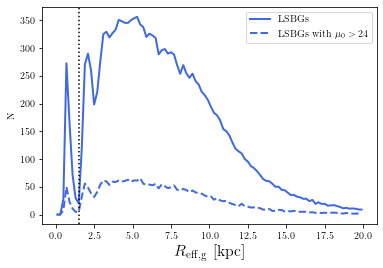

In [25]:
r_dist_blue, r_dist_udg_blue = phys_radius_dist(r_hists=r_hists_blue, r_hists_udg=r_hists_blue_udg, zldist=zldist_blue_fiducial, bin_means=bin_means_blue, color='royalblue')


## UDG Proportion 

We generate a UDG size mask, ensuring that the physical radii have a size greater than 1.5 kpc, and measure the proportion of galaxies that pass the central surface brightness cut and the size cut. We then calculate how many of the galaxies meet the requirements to be classified as a UDG. 

In [26]:
mask_UDGS_red = bin_means_red>1.5
pass_size_cut_red = np.sum(r_dist_red[mask_UDGS_red])/np.sum(r_dist_red)

In [27]:
mask_UDGS_blue = bin_means_blue>1.5
pass_size_cut_blue = np.sum(r_dist_blue[mask_UDGS_blue])/np.sum(r_dist_blue)

In [28]:
print('%0.2f percentage of the LSBGs that pass the central surface brightness cut pass also the size cut'%pass_size_cut_red)

0.80 percentage of the LSBGs that pass the central surface brightness cut pass also the size cut


In [29]:
print('%0.2f percentage of the LSBGs that pass the central surface brightness cut pass also the size cut'%pass_size_cut_blue)

0.96 percentage of the LSBGs that pass the central surface brightness cut pass also the size cut


In [30]:
print('In total, %0.2f percentage of all red LSBS are UDGS.'%(pass_size_cut_red*pass_central_cut_red))

In total, 0.28 percentage of all red LSBS are UDGS.


In [31]:
print('In total, %0.2f percentage of all blue LSBS are UDGS.'%(pass_size_cut_blue*pass_central_cut_blue))

In total, 0.16 percentage of all blue LSBS are UDGS.
